In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('data/names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])


32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [6]:
# build the dataset (Previously we were doing trigram;2 characters -> 1 output, here we have context size of 8)
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [7]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])


........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [ ]:
# Near copy paste of the layers we have developed in trigram
# -----------------------------------------------------------------------------------------------
class Linear:
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d():
    def __init__(self, n_hidden, eps=1e-5, momentum=0.1):
        self.momentum = momentum
        self.eps = eps
        self.training = True

        self.bngain = torch.ones(1, n_hidden)
        self.bnbias = torch.zeros(1, n_hidden)
        self.bnmean_running = torch.zeros(1, n_hidden)
        self.bnstd_running = torch.ones(1, n_hidden)

    def __call__(self, logits):
        if self.training:
            if logits.dim() == 2:
                dim = 0
            elif logits.dim() == 3:
                dim = (0, 1)
            mean = logits.mean(dim=dim, keepdim=True)
            std = logits.std(dim=dim, keepdim=True)
        else:
            mean = self.bnmean_running
            std = self.bnstd_running
        xhat = (logits - mean) / (std + self.eps)
        self.out = self.bngain * xhat + self.bnbias
        if self.training:
            with torch.no_grad():
                self.bnmean_running = (1 - self.momentum) * self.bnmean_running + self.momentum * mean
                self.bnstd_running = (1 - self.momentum) * self.bnstd_running + self.momentum * std
        return self.out

    def parameters(self):
        return [self.bngain, self.bnbias]


class Tanh(object):
    def __call__(self, input):
        self.out = torch.tanh(input)
        return self.out

    def parameters(self):
        return []

class Embedding():
    def __init__(self, num_embedding, embedding_dim):
        self.weight = torch.randn((num_embedding, embedding_dim)) # Embedding matrix

    def __call__(self, Ix):
        self.out = self.weight[Ix]
        return self.out

    def parameters(self):
        return [self.weight]

class FlattenConsecutive():
    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T // self.n, C * self.n)
        if x.shape[1] == 1:
            x = x.squeeze(dim=1)
        self.out = x
        return self.out

    def parameters(self):
        return []

class Sequential():
    def __init__(self, layers):
        self.layers = layers
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [9]:
torch.manual_seed(42)

In [ ]:
embed_dim = 10
n_hidden = 68
model = Sequential([
    Embedding(num_embedding=vocab_size, embedding_dim=embed_dim),
    FlattenConsecutive(2), Linear(embed_dim * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])
parameters = model.parameters()
print("Total parameters = ", sum(p.nelement() for p in parameters))

# lets make sure that the use grad is true for all parameters.
for p in parameters:
    p.requires_grad_(True)

Total parameters =  170897


In [16]:
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(logits.shape) # 4 examples, each of vocab_size classes

for layer in model.layers:
    print(layer.__class__.__name__, ":", layer.out.shape)

torch.Size([4, 27])
Embedding : torch.Size([4, 8, 10])
FlattenConsecutive : torch.Size([4, 4, 20])
Linear : torch.Size([4, 4, 200])
BatchNorm1d : torch.Size([4, 4, 200])
Tanh : torch.Size([4, 4, 200])
FlattenConsecutive : torch.Size([4, 2, 400])
Linear : torch.Size([4, 2, 200])
BatchNorm1d : torch.Size([4, 2, 200])
Tanh : torch.Size([4, 2, 200])
FlattenConsecutive : torch.Size([4, 400])
Linear : torch.Size([4, 200])
BatchNorm1d : torch.Size([4, 200])
Tanh : torch.Size([4, 200])
Linear : torch.Size([4, 27])


In [159]:
lr = 0.01
epochs = 100000
BATCH_SIZE = 32
lossi = []

for epoch in range(epochs):
    # lets take a mini batch of input to do sgd so that it trains fast
    ix = torch.randint(0, Xtr.shape[0], (BATCH_SIZE, ))
    Xb, Yb = Xtr[ix], Ytr[ix]
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)
    # Do backward propagation
    for p in parameters:
        p.grad = None
    loss.backward()
    lossi.append(loss.log10().item())
    for p in parameters:
        p.data += -lr * p.grad

    print(f'Epoch: {epoch}, loss: {loss.item()}')

Epoch: 0, loss: 3.5996174812316895
Epoch: 1, loss: 3.3519132137298584
Epoch: 2, loss: 3.3746466636657715
Epoch: 3, loss: 3.680799961090088
Epoch: 4, loss: 3.5585789680480957
Epoch: 5, loss: 3.423330068588257
Epoch: 6, loss: 3.2246315479278564
Epoch: 7, loss: 3.4086313247680664
Epoch: 8, loss: 3.685412645339966
Epoch: 9, loss: 3.278282642364502
Epoch: 10, loss: 3.265103340148926
Epoch: 11, loss: 3.336397886276245
Epoch: 12, loss: 3.3577399253845215
Epoch: 13, loss: 3.3003761768341064
Epoch: 14, loss: 3.3296751976013184
Epoch: 15, loss: 3.4617207050323486
Epoch: 16, loss: 3.316702365875244
Epoch: 17, loss: 3.247040033340454
Epoch: 18, loss: 3.4139695167541504
Epoch: 19, loss: 3.242140293121338
Epoch: 20, loss: 3.440223455429077
Epoch: 21, loss: 3.3634886741638184
Epoch: 22, loss: 3.3292951583862305
Epoch: 23, loss: 3.108035087585449
Epoch: 24, loss: 3.427222490310669
Epoch: 25, loss: 3.2749953269958496
Epoch: 26, loss: 3.2986021041870117
Epoch: 27, loss: 3.305192708969116
Epoch: 28, loss

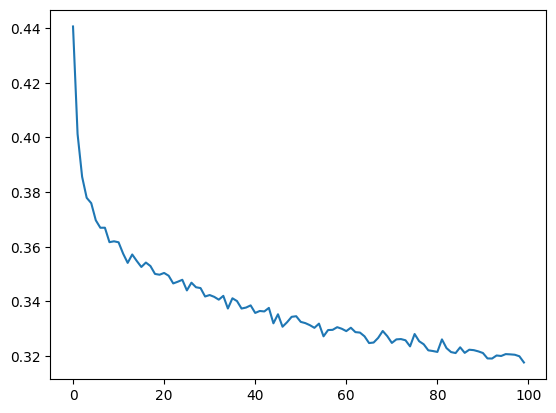

In [150]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(dim=1))

In [151]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [152]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.0711209774017334
val 2.1103992462158203


In [153]:
# sample from the model
for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

aqayse.
nq.
laigo.
shara.
jayiana.
daur.
olunn.
jarrain.
saysln.
ksrisantu.
amyla.
askodanse.
fndicka.
missieg.
novlemel.
ron.
namareie.
seyaber.
mintya.
jorelle.


In [145]:
list(range(10))[1::2]

[1, 3, 5, 7, 9]

In [146]:
e = torch.randn((4, 8, 10))
# torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2).shape
B, T, C = e.shape
n = 2 # if we want to concatenate two instances (like above torch.cat) instead of 8 instances in (e.view(4, -1))
e.view(B, -1, C * n).shape

torch.Size([4, 4, 20])